# network is already built so why bother building again this one will focus more on changing Taus

2024-01-09 11:26:30,189 [INFO] Created log file


Mechanisms already loaded from path: /Users/gregglickert/Documents/GitHub/Network-Modeling-Manual/Chapter-5-Building-Networks/Section-X-PING-network/components/mechanisms.  Aborting.
2024-01-09 11:26:30,244 [INFO] Building cells.
2024-01-09 11:26:41,073 [INFO] Building recurrent connections
2024-01-09 11:26:56,239 [INFO] Building virtual cell stimulations for noise
2024-01-09 11:26:56,446 [INFO] Running simulation for 500.000 ms with the time step 0.100 ms
2024-01-09 11:26:56,448 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-01-09 11:26:56,449 [INFO] Block save every 5000 steps
2024-01-09 11:27:20,647 [INFO]     step:5000 t_sim:500.00 ms
2024-01-09 11:27:20,677 [INFO] Simulation completed in 24.23 seconds 


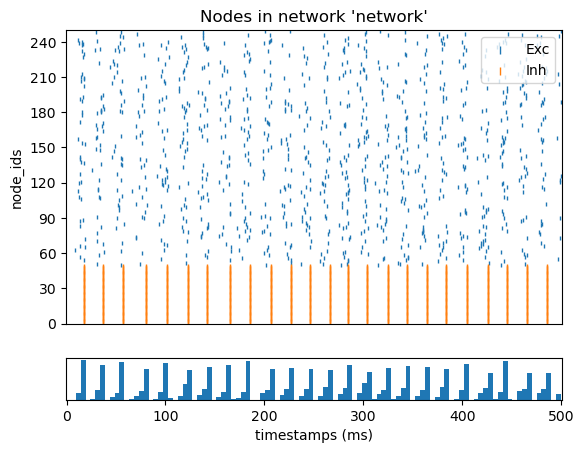

The network is oscilating around 49.250535 hz


In [ ]:
# Download needed packages and files
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages and repo if in colab
    !pip install bmtk &> /dev/null               
    !pip install neuron &> /dev/null
    !git clone https://github.com/GregGlickert/Neural-Modeling-Manual.git &> /dev/null 
    %cd Neural-Modeling-Manual/Chapter-5-Building-Networks/Section-X-PING-network/

if(os.path.exists('components/mechanisms/x86_64')==False): 
    %cd components/mechanisms/       
    os.system('nrnivmodl') # compile modfiles. Return 0 for success, 1 for failure.
    %cd ../..

from bmtk.simulator import bionet
import ipywidgets as widgets
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import json
from neuron import h

global tau1_exc2exc
global tau2_exc2exc
global tau1_exc2inh
global tau2_exc2inh
global tau1_inh2exc
global tau2_inh2exc
global tau1_inh2inh
global tau2_inh2inh

tau1_exc2exc = 0.5
tau2_exc2exc = 3
tau1_exc2inh = 0.5
tau2_exc2inh = 3

tau1_inh2exc = 0.5
tau2_inh2exc = 9
tau1_inh2inh = 0.5
tau2_inh2inh = 9

def model():
    h.nrnmpi_init()
    pc = h.ParallelContext()  # object to access MPI methods
    MPI_size = int(pc.nhost())
    MPI_rank = int(pc.id())
    # run the model 
    conf = bionet.Config.from_json('simulation_config.json')
    conf.build_env()
    net = bionet.BioNetwork.from_config(conf)
    sim = bionet.BioSimulator.from_config(conf, network=net)
    sim.run();
    pc.barrier();
    pc.gid_clear()
    pc.done()


    #ploting stuff
    plot_raster(config_file='simulation_config.json', group_by='pop_name')
    f = h5py.File('output/spikes.h5')
    spikes_df = pd.DataFrame({'node_ids': f['spikes']['network']['node_ids'], 'timestamps': f['spikes']['network']['timestamps']})
    cells = range(5,6)
    cell_spikes = spikes_df[spikes_df['node_ids'].isin(cells)]
    sorted_spikes = np.sort(cell_spikes['timestamps'])
    ISI = np.diff(sorted_spikes)
    mean_ISI = np.mean(ISI)
    freq = 1000/mean_ISI
    print("The network is oscilating around {:f} hz".format(freq))
    plt.show()

def run_model(*arges):
    clear_output()
    model()
    display(ui)

def change_tau(*arges):
    global tau1_exc2exc
    global tau2_exc2exc
    global tau1_exc2inh
    global tau2_exc2inh
    global tau1_inh2exc
    global tau2_inh2exc
    global tau1_inh2inh
    global tau2_inh2inh
    path = 'components/synaptic_models/' + str(json_select.value) + '.json'
    clear_output()
    tau1 = w_tau1.value
    tau2 = w_tau2.value
    if str(json_select.value) == 'Exc2Exc':
        tau1_exc2exc = w_tau1.value 
        tau2_exc2exc = w_tau2.value
    if str(json_select.value) == 'Exc2Inh':
        tau1_exc2inh = w_tau1.value 
        tau2_exc2inh = w_tau2.value
    if str(json_select.value) == 'Inh2Exc':
        tau1_inh2exc = w_tau1.value 
        tau2_inh2exc = w_tau2.value
    if str(json_select.value) == 'Inh2Inh':
        tau1_inh2inh = w_tau1.value 
        tau2_inh2inh = w_tau2.value
    with open(path, 'r+') as f:
        data = json.load(f)
        data['tau1'] = float(tau1) # <--- edit `initW` value.
        data['tau2'] = float(tau2) # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part

    display(ui)

def change_slider(*arges):
    if str(json_select.value) == 'Exc2Exc':
        w_tau1.value = tau1_exc2exc
        w_tau2.value = tau2_exc2exc
    if str(json_select.value) == 'Exc2Inh':
        w_tau1.value = tau1_exc2inh
        w_tau2.value = tau2_exc2inh
    if str(json_select.value) == 'Inh2Exc':
        w_tau1.value = tau1_inh2exc
        w_tau2.value = tau2_inh2exc
    if str(json_select.value) == 'Inh2Inh':
        w_tau1.value = tau1_inh2inh
        w_tau2.value = tau2_inh2inh

w_run = widgets.Button(description='Run',icon='history',button_style='primary')
w_edit = widgets.Button(description='Edit')
json_select = widgets.ToggleButtons(
    options=['Exc2Exc', 'Exc2Inh', 'Inh2Exc', 'Inh2Inh'],
    value = None,
    description='Json to edit:',
    disabled=False,
    button_style='')
w_tau1 = widgets.FloatSlider(value=0.5,min=0.1,max=2, step=0.1,description='Tau1',style=dict(description_width='initial'))
w_tau2 = widgets.FloatSlider(value=3,min=1,max=30, step=0.1,description='Tau2',style=dict(description_width='initial'))
w_run.on_click(run_model)
w_edit.on_click(change_tau)
json_select.observe(change_slider,'value')

ui = VBox([HBox([w_run,w_edit]),json_select,w_tau1,w_tau2])
ui

# By editing the Tua values you can greatly change how the network acts. If you change the Tau 2 for the Inh2Exc conenction you can greatly effect the oscilating effect of the network